In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [32]:
# 2. Đọc file csv và gắn index với giá AQI
df = pd.read_csv('/content/drive/MyDrive/Dataset/Test/DaNang.csv')

In [33]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df[df['date'] < '2024-06-01']

In [34]:
# 10. Generate future predictions
def predict_future(model, data, time_step, future_days, scaler):
    temp_input = data[-time_step:].reshape(1, -1)
    temp_input = list(temp_input[0])
    future_output = []

    for _ in range(future_days):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]
        input_data = np.array(temp_input).reshape(1, time_step, 1)
        prediction = model.predict(input_data, verbose=0)
        temp_input.append(prediction[0][0])
        future_output.append(prediction[0][0])

    future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))
    return future_output


In [35]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [36]:
def train_test_split_and_predict(tran_ratio=0.7):
  df1 = df.reset_index()['AQI']
# 3. Scaler data
  scaler = MinMaxScaler(feature_range=(0, 1))
  df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
# 4. Chia train test
  train_size = int(tran_ratio * len(df1))
  test_size = len(df1) - train_size
  train_data = df1[:train_size]
  test_data = df1[train_size:]
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
  time_step = 100
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# 8. Define GRU Model
  model = Sequential()
  model.add(GRU(64, input_shape=(time_step, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train
  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Predict on train and test data
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

# Inverse transform predictions
  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)

# Predict for 30, 60, 90 days
  future_30_days = predict_future(model, df1, time_step, 30, scaler)
  future_60_days = predict_future(model, df1, time_step, 60, scaler)
  future_90_days = predict_future(model, df1, time_step, 90, scaler)
  plt.figure(figsize=(15, 8))

  # Plot train data
  plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
  plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
  plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
  plt.plot(np.arange(len(df1), len(df1) + 30), future_30_days, label="30 Days Prediction")

    # Add labels and legend
  plt.xlabel('Days')
  plt.ylabel('AQI')
  plt.title(f'AQI Predictions - 30 Days prediction')
  plt.legend()
  plt.show()

  # Plot train data
  plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
  plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
  plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
  plt.plot(np.arange(len(df1), len(df1) + 60), future_60_days, label="60 Days Prediction")

    # Add labels and legend
  plt.xlabel('Days')
  plt.ylabel('AQI')
  plt.title(f'AQI Predictions - 60 Days prediction')
  plt.legend()
  plt.show()

  # Plot train data
  plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
  plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
  plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
  plt.plot(np.arange(len(df1), len(df1) + 90), future_90_days, label="90 Days Prediction")

    # Add labels and legend
  plt.xlabel('Days')
  plt.ylabel('AQI')
  plt.title(f'AQI Predictions - 90 Days prediction')
  plt.legend()
  plt.show()

# Calculate MAE, RMSE, and MAPE for test predictions
  mae = mean_absolute_error(y_test, test_predict)
  rmse = np.sqrt(mean_squared_error(y_test, test_predict))
  mape = mean_absolute_percentage_error(y_test, test_predict)

  print(f'MAE: {mae}')
  print(f'RMSE: {rmse}')
  print(f'MAPE: {mape}')


Epoch 1/100
33/33 [==============================] - 5s 79ms/step - loss: 0.0083 - val_loss: 0.0355
Epoch 2/100
33/33 [==============================] - 2s 63ms/step - loss: 0.0057 - val_loss: 0.0332
Epoch 3/100
33/33 [==============================] - 2s 62ms/step - loss: 0.0052 - val_loss: 0.0323
Epoch 4/100
33/33 [==============================] - 2s 68ms/step - loss: 0.0051 - val_loss: 0.0312
Epoch 5/100
33/33 [==============================] - 3s 98ms/step - loss: 0.0049 - val_loss: 0.0309
Epoch 6/100
33/33 [==============================] - 3s 76ms/step - loss: 0.0049 - val_loss: 0.0304
Epoch 7/100
33/33 [==============================] - 2s 64ms/step - loss: 0.0047 - val_loss: 0.0303
Epoch 8/100
33/33 [==============================] - 2s 62ms/step - loss: 0.0046 - val_loss: 0.0304
Epoch 9/100
33/33 [==============================] - 2s 62ms/step - loss: 0.0046 - val_loss: 0.0298
Epoch 10/100
33/33 [==============================] - 2s 63ms/step - loss: 0.0045 - val_loss: 0.0297

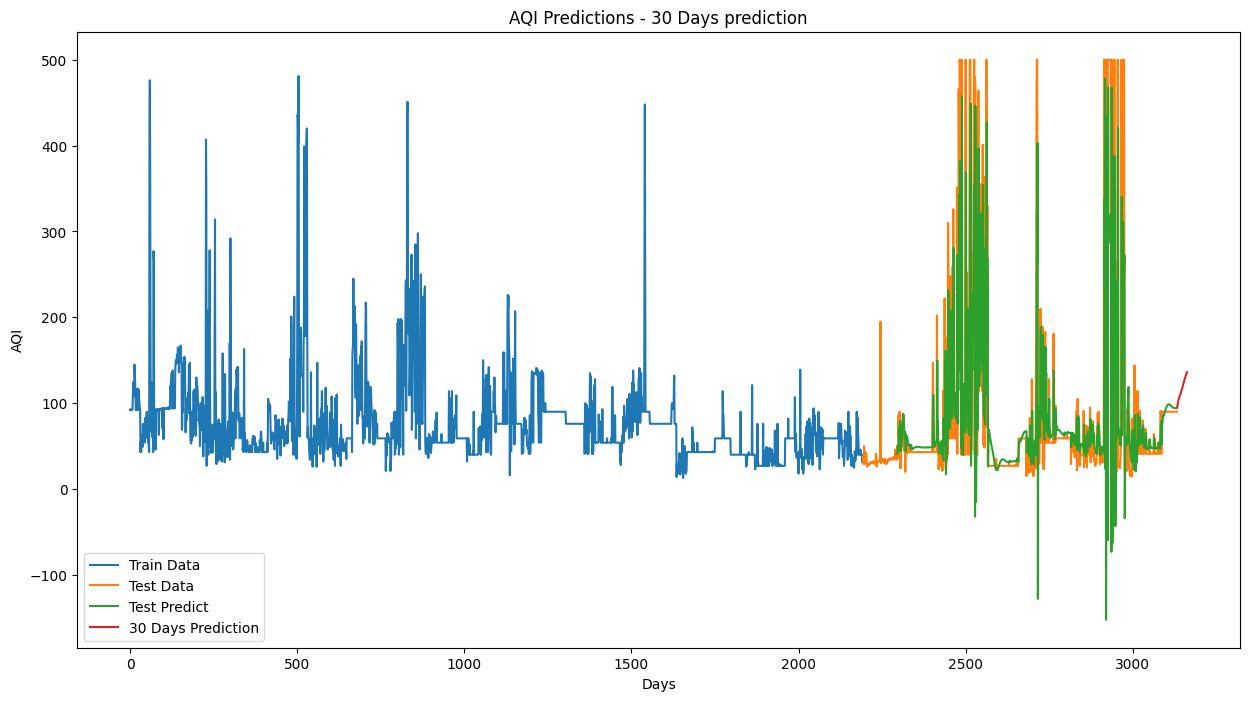

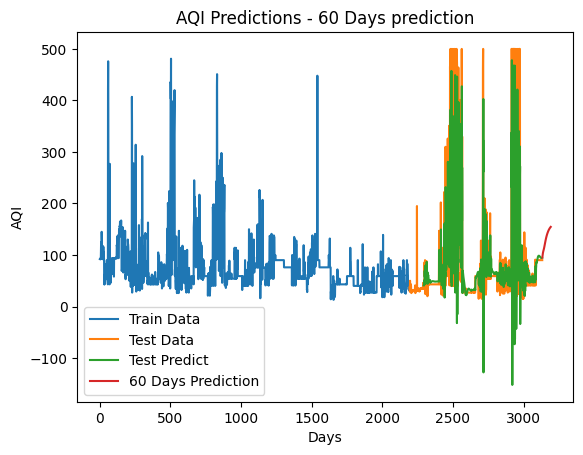

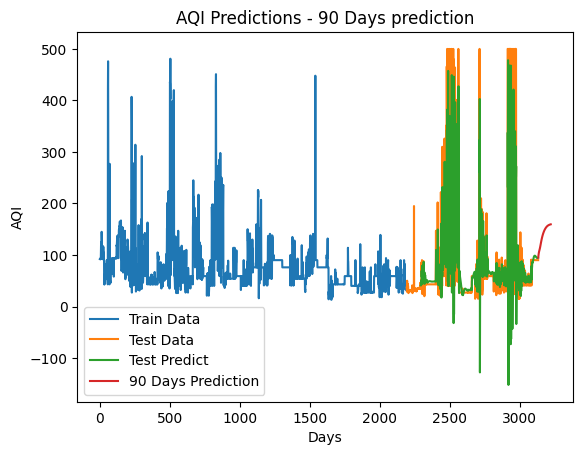

MAE: 85.7589086545752
RMSE: 117.04926121134231
MAPE: 1094.1237073749917
Epoch 1/100
38/38 [==============================] - 6s 87ms/step - loss: 0.0112 - val_loss: 0.0324
Epoch 2/100
38/38 [==============================] - 4s 99ms/step - loss: 0.0072 - val_loss: 0.0287
Epoch 3/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0069 - val_loss: 0.0274
Epoch 4/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0067 - val_loss: 0.0265
Epoch 5/100
38/38 [==============================] - 2s 61ms/step - loss: 0.0065 - val_loss: 0.0261
Epoch 6/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0064 - val_loss: 0.0255
Epoch 7/100
38/38 [==============================] - 3s 88ms/step - loss: 0.0063 - val_loss: 0.0256
Epoch 8/100
38/38 [==============================] - 3s 91ms/step - loss: 0.0062 - val_loss: 0.0251
Epoch 9/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0062 - val_loss: 0.0250
Epoch 10/100
38/38 [========

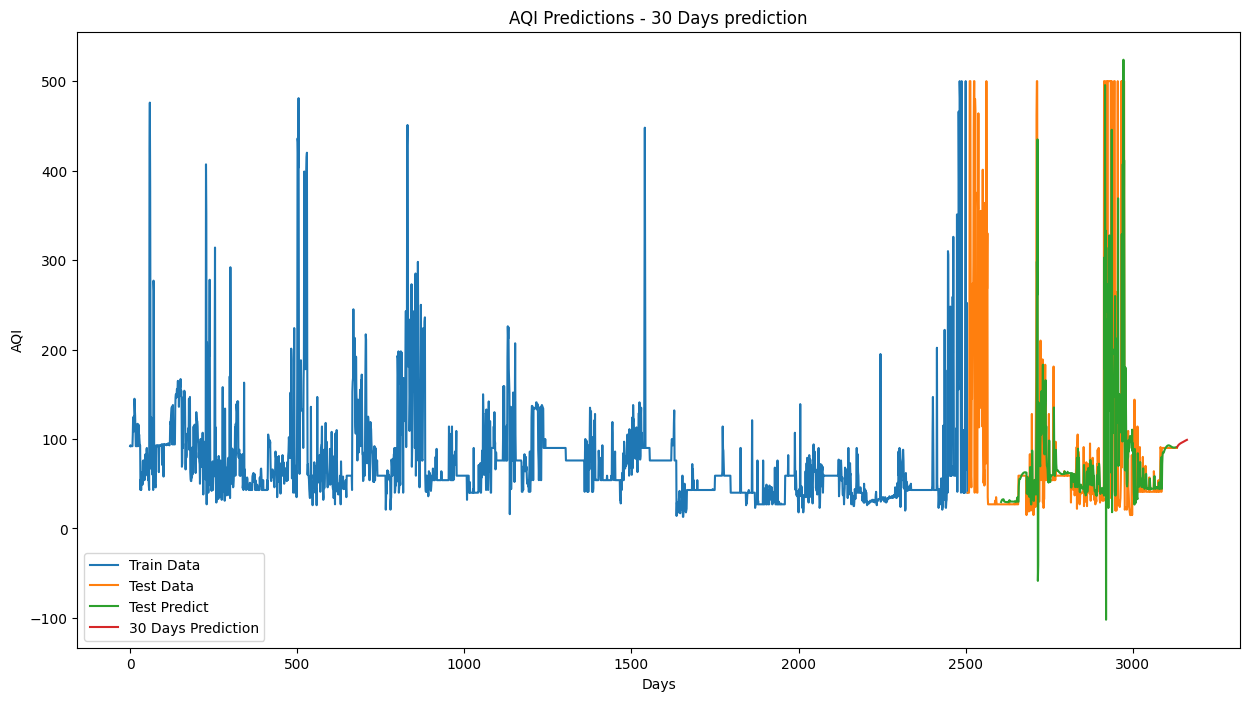

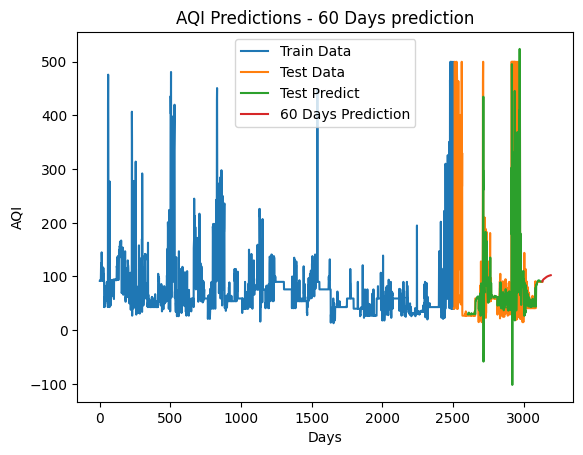

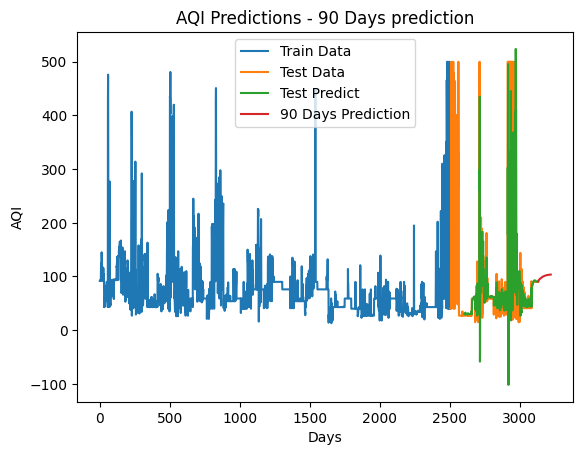

MAE: 77.82037895344048
RMSE: 102.37022542556299
MAPE: 1340.9182921106865
Epoch 1/100
43/43 [==============================] - 6s 88ms/step - loss: 0.0114 - val_loss: 0.0505
Epoch 2/100
43/43 [==============================] - 4s 100ms/step - loss: 0.0095 - val_loss: 0.0480
Epoch 3/100
43/43 [==============================] - 3s 68ms/step - loss: 0.0091 - val_loss: 0.0471
Epoch 4/100
43/43 [==============================] - 3s 66ms/step - loss: 0.0089 - val_loss: 0.0464
Epoch 5/100
43/43 [==============================] - 3s 65ms/step - loss: 0.0088 - val_loss: 0.0462
Epoch 6/100
43/43 [==============================] - 3s 79ms/step - loss: 0.0086 - val_loss: 0.0465
Epoch 7/100
43/43 [==============================] - 4s 95ms/step - loss: 0.0085 - val_loss: 0.0459
Epoch 8/100
43/43 [==============================] - 3s 64ms/step - loss: 0.0085 - val_loss: 0.0459
Epoch 9/100
43/43 [==============================] - 3s 66ms/step - loss: 0.0085 - val_loss: 0.0462
Epoch 10/100
43/43 [======

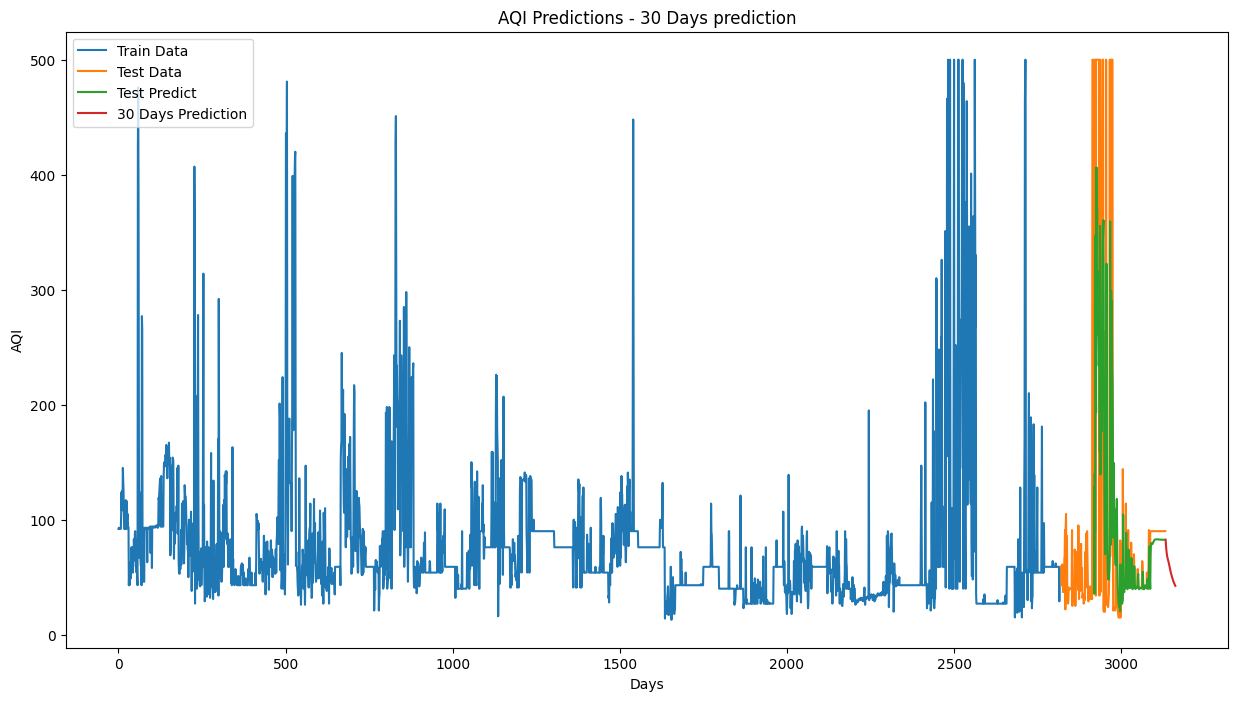

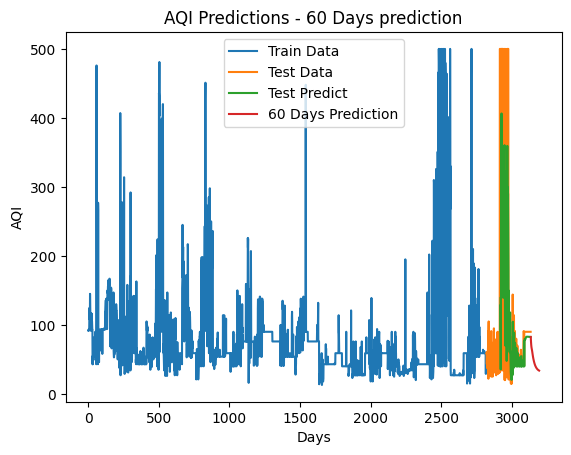

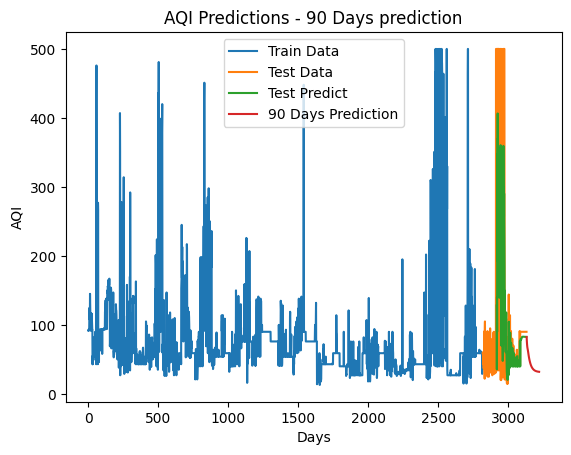

MAE: 96.50281149668214
RMSE: 127.7642608634613
MAPE: 1388.005188276313


In [37]:
train_test_split_and_predict(0.7)
train_test_split_and_predict(0.8)
train_test_split_and_predict(0.9)